In [1]:
%matplotlib inline
import pandas as pd
from itables import show
from common.w2v_model import W2VModel
from analysis_tools.corpus_stats import get_corpus_stats
from analysis_tools.cosine_similarity_time_series import cosine_similarity_over_years
from analysis_tools.weat_time_series import compute_weat_over_years
from analysis_tools.semantic_drift import track_yearly_drift, compute_similarity_to_previous_year
from analysis_tools.average_relatedness_by_year import track_word_semantic_drift

# **Analyze Semantic Change**
## **Goal**: Use trained `Word2vec` emeddings to examine semantic change over time. 

The `hist_w2v` package contains several tools useful in quantifying how much word meanings have changed over the years. Before using these tools, it helps to set a model path variable. Most commonly, this will point to the `norm_and_align` directory. We'll also set a `corpus_path` variable pointing to the yearly corpus data.

In [2]:
model_path =  '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models_final/norm_and_align'
corpus_path = '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/data'

### `get_corpus_stats` function
For some analyses, it's useful to collect information about the training corpora—in particular, their sizes. The `corpus_stats` module does this. This can talk almost an hour, so the data get saved in the `out_dir` directory. Once the file has been created, you can regenerate it by setting `overwrite=True`. Otherwise, there is no need to run this function again; you can load the existing CSV file into a `pandas` data frame at any point.

In [3]:
df = get_corpus_stats(
    data_dir=corpus_path,
    out_dir=corpus_path,
    overwrite=True
)

Processing corpus files:   0%|          | 0/527 [00:00<?, ?file/s]

Statistics saved to /vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/data/corpus_stats.csv


In [4]:
df

,unique_ngrams,total_freq,total_docs
year,,,
1470,14,25,21
1472,8284,26438,13255
1475,24989,61149,44143
1476,2265,3222,3118
1477,35079,109736,61171
...,...,...,...
2015,158778373,4457210868,3988095530
2016,158175628,4411250123,3956215674
2017,156648732,4862468892,4376641034


### `compare_words_cosim` method

Let's say we want to measure the relationship between three pairs of words — _horse_ and _donkey_, _horse_ and _lizard_ , and _horse_ and _amoeba_ — in the 2019 corpus. We first create a `W2VModel` instance for the 2019 embeddings. Then, we call the `compare_words_cosim` method for our words.

In [3]:
year = 2019
model = W2VModel(f'{model_path}/w2v_y{year}_wbnone_vs200_w5_mc20_sg1_e10.kv')

word1, word2 = 'horse', 'donkey'
similarity = model.compare_words_cosim(word1, word2)
print(f"cos(Φ) of \'{word1}\' and \'{word2}\' in {year} = {similarity:.4f}")

word1, word2 = 'horse', 'lizard'
similarity = model.compare_words_cosim(word1, word2)
print(f"cos(Φ) of \'{word1}\' and \'{word2}\' in {year} = {similarity:.4f}")

word1, word2 = 'horse', 'amoeba'
similarity = model.compare_words_cosim(word1, word2)
print(f"cos(Φ) of \'{word1}\' and \'{word2}\' in {year} = {similarity:.4f}")

cos(Φ) of 'horse' and 'donkey' in 2019 = 0.6740
cos(Φ) of 'horse' and 'lizard' in 2019 = 0.3166
cos(Φ) of 'horse' and 'amoeba' in 2019 = 0.1519


The results are about what would would expect!

### `compare_models_cosim` method
Suppose we want to compare the semantic similarity of the _same_ words across _models_. We can use the `compare_models_cosim` method to compute the average cosine similarity between shared words in two models. Or, if we specify the `word` parameter, we can compute similarity for a single word across the models.

In [4]:
model = W2VModel(f'{model_path}/w2v_y2018_wbnone_vs200_w5_mc20_sg1_e10.kv')
reference_model = W2VModel(f'{model_path}/w2v_y2019_wbnone_vs200_w5_mc20_sg1_e10.kv')

cosim_mean, cosim_sd, shared_words = model.compare_models_cosim(reference_model)
print(f"Overall similarity between models:\n  cos(Φ) mean = {cosim_mean:.4f}\n  cos(Φ) SD = {cosim_sd:.4f}\n  shared words: {shared_words}\n")

word = 'horse'
cosim, _, _ = model.compare_models_cosim(reference_model, word)
print(f"Similarity of \'{word}\' between models:\n  cos(Φ) = {cosim:.4f}\n")

Overall similarity between models:
  cos(Φ) mean = 0.8536
  cos(Φ) SD = 0.0570
  shared words: 77246

Similarity of 'horse' between models:
  cos(Φ) = 0.9445



### `track_yearly_drift` function

⚠️ No models found for these years: [1832]


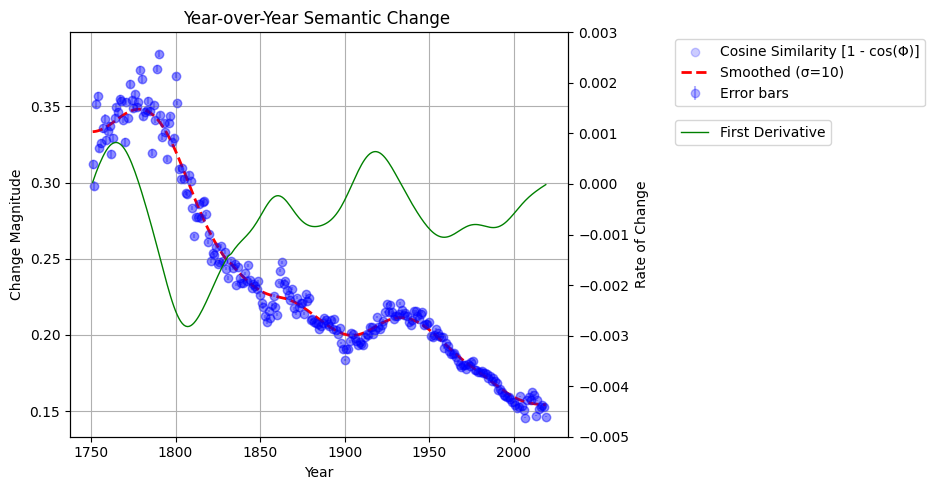

In [5]:
drift_scores = track_yearly_drift(
    start_year=1750,
    end_year=2019,
    model_dir=model_path,
    plot=True,
    error_type='CI',
    smooth=True,
    sigma=10,
    confidence=0.99
)

show(drift_scores)

In [3]:
df_regressors = pd.read_csv(f"{corpus_path}/corpus_stats.csv", index_col="year")
df_regressors

,unique_ngrams,total_freq,total_docs
year,,,
1470,14,25,21
1472,8284,26438,13255
1475,24989,61149,44143
1476,2265,3222,3118
1477,35079,109736,61171
...,...,...,...
2015,158778373,4457210868,3988095530
2016,158175628,4411250123,3956215674
2017,156648732,4862468892,4376641034


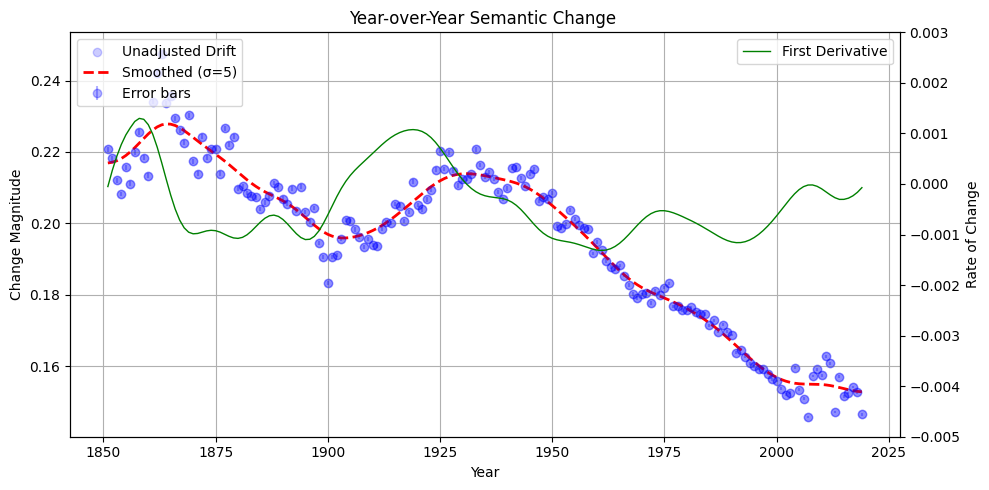

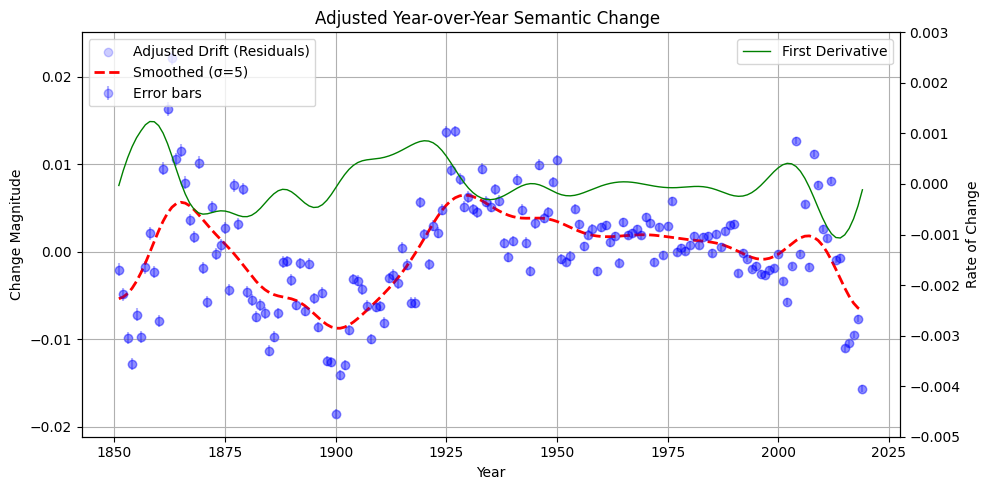

In [13]:
df_results = track_yearly_drift(
    start_year=1850, 
    end_year=2019, 
    model_dir=model_path,
    plot=True, 
    smooth=True, 
    sigma=5,
    df=df_regressors,
    regress_on="unique_ngrams"
)

### `mean_cosine_similarity_to_all` class

In [14]:
model = W2VModel(f'{model_path}w2v_y2019_wbnone_vs200_w5_mc20_sg1_e10.kv')

mean_sim = model.mean_cosine_similarity_to_all('person')
print(f"Mean cosine similarity = {mean_sim:.4f}")

Mean cosine similarity = 0.1547


Tracking semantic drift for word: 'person' (Excluding: 0 words)
⚠️ No models found for these years: [1832]


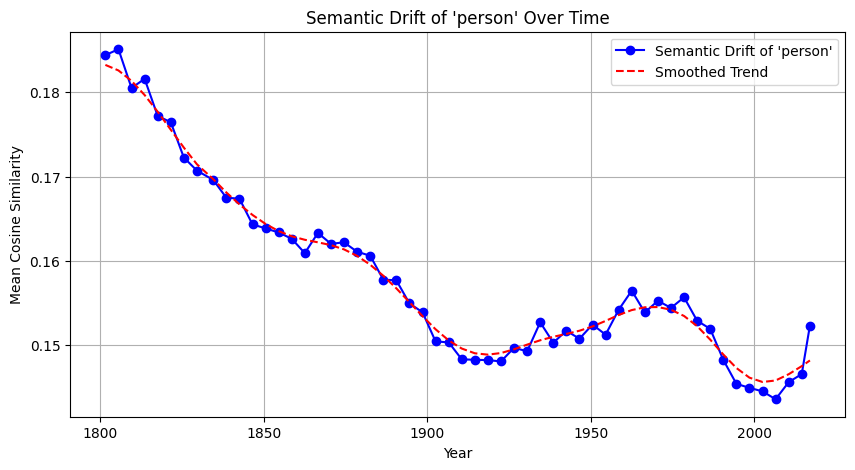

{1800: (0.18220598460045137, 0),
 1801: (0.18706374157482505, 0),
 1802: (0.18375759158986538, 0),
 1803: (0.18452610587701293, 0),
 1804: (0.18469023384954836, 0),
 1805: (0.186115526939119, 0),
 1806: (0.18702718236734128, 0),
 1807: (0.1825194794074326, 0),
 1808: (0.18153108362544193, 0),
 1809: (0.1817678259656314, 0),
 1810: (0.18211585152422258, 0),
 1811: (0.17654644552374418, 0),
 1812: (0.17973027867034044, 0),
 1813: (0.1810743840214455, 0),
 1814: (0.18499591135460927, 0),
 1815: (0.18051199186341266, 0),
 1816: (0.17470861823225609, 0),
 1817: (0.1760171809828018, 0),
 1818: (0.17767557289143593, 0),
 1819: (0.1803029292043517, 0),
 1820: (0.17421469162754916, 0),
 1821: (0.17356232541134792, 0),
 1822: (0.17732419313972367, 0),
 1823: (0.18064309950585583, 0),
 1824: (0.1740215683038627, 0),
 1825: (0.17123086518187597, 0),
 1826: (0.17250729508727752, 0),
 1827: (0.17123567881758608, 0),
 1828: (0.17599583014071274, 0),
 1829: (0.16914702487038621, 0),
 1830: (0.16789581

In [12]:
track_word_semantic_drift(
    word='person',
    start_year=1800,
    end_year=2017,
    model_dir=f'{model_path}',
    plot=4,
    smooth=True,
    sigma=2
)

### `cosine_similarity_over_years` function

The `cosine_similarity_time_series` function uses the `cosine_similarity` method to track the relationship between a pair of words across time. Simply specify your two words (`word1` and `word2`), a `start_year` and `end_year`, and the model directory. You'll get a list of years and associated cosine similarities; set `plot=True` if you want to graph them. The model will skip any years for which there is no model or there words aren't in the models' shared vocabulary.

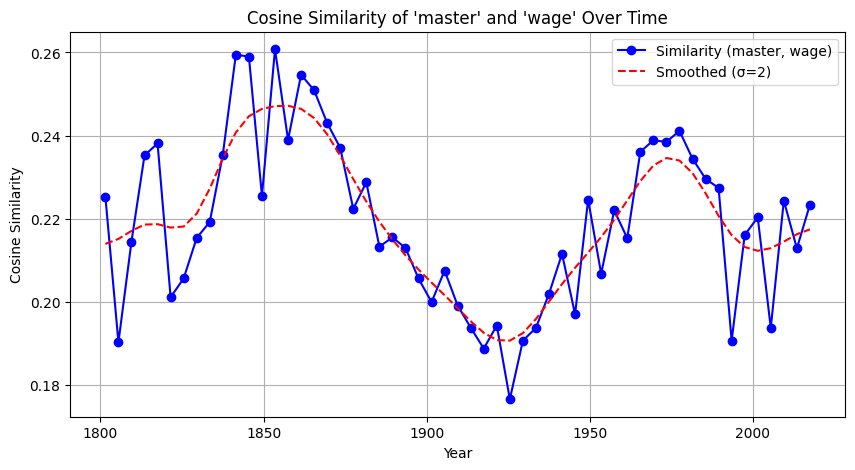

{1800: 0.19677594,
 1801: 0.22306743,
 1802: 0.28393793,
 1803: 0.19759385,
 1804: 0.23973407,
 1805: 0.092068836,
 1806: 0.18277109,
 1807: 0.24666321,
 1808: 0.1802287,
 1809: 0.20027657,
 1810: 0.26287633,
 1811: 0.21471873,
 1812: 0.212767,
 1813: 0.25406772,
 1814: 0.24278966,
 1815: 0.23139349,
 1816: 0.23452888,
 1817: 0.22834945,
 1818: 0.23154657,
 1819: 0.25801447,
 1820: 0.21230732,
 1821: 0.15670638,
 1822: 0.22419219,
 1823: 0.21140203,
 1824: 0.23157635,
 1825: 0.18039387,
 1826: 0.215432,
 1827: 0.19530265,
 1828: 0.26661736,
 1829: 0.19717415,
 1830: 0.22176003,
 1831: 0.17611569,
 1833: 0.21422096,
 1834: 0.22222446,
 1835: 0.24533823,
 1836: 0.22888534,
 1837: 0.2447776,
 1838: 0.2362119,
 1839: 0.23171332,
 1840: 0.26928532,
 1841: 0.26262358,
 1842: 0.23574622,
 1843: 0.27017078,
 1844: 0.26310122,
 1845: 0.25333264,
 1846: 0.22546107,
 1847: 0.29403722,
 1848: 0.2584366,
 1849: 0.19736835,
 1850: 0.22110845,
 1851: 0.22517072,
 1852: 0.24303715,
 1853: 0.23837921,


In [16]:
cosine_similarity_over_years(
    word1='master',
    word2='wage',
    start_year=1800,
    end_year=2019,
    model_dir=f'{model_path}',
    plot=4,
    smooth=True,
    sigma=2
)

### `compute_weat` method
This method runs a Word Embedding Association Test (WEAT) as described in [Caliskan, Bryson, and Narayanan, 2017](https://www.science.org/doi/10.1126/science.aal4230). The WEAT is a close analog of the Implicit Association Test (IAT; [Greenwald, McGhee, & Schwarz, 1995](https://psycnet.apa.org/record/1998-02892-004))—but, whereas the IAT uses reaction latencies to measure a person's cognitive association between two mental category constrasts, the WEAT uses cosine similarities to measure the semantic association between linguistic category contrasts in a corpus.

Just as with the IAT, the WEAT requires that you select two constrasting "target" categories (e.g., _man_ vs. _woman_) and two contrasting "attribute" categories (e.g., _science_ vs. _art_), as well as a list of exemplars of each of these four categories. The `compute_weat` method then:
1. calculates the mean of all pairwise cosine similarities among exemplars within each target–attribute combination (e.g., $\bar c_{man, science}$, $\bar c_{man, art}$, $\bar c_{woman, science}$, $\bar c_{woman, art}$),
2. takes the difference in mean similarity between combinations involving the same target (e.g., $\bar c_{man, science} - \bar c_{man, art}$ and $\bar c_{woman, science} - \bar c_{woman, art}$),
3. subtracts these differences from one another (e.g., $[(\bar c_{man, science} - \bar c_{man, art}) - (\bar c_{woman, science} - \bar c_{woman, art})]$), and
4. divides this difference by the pooled standard deviation across all exemplars for all target–attribute pairs.

This calculation yields an effect size, $d$, analogous to that used in IAT research. Higher scores indicate a stronger relative semantic link between the first target and first attribute (e.g., between _man_ and _science_).

In [4]:
model = W2VModel(f'{model_path}/w2v_y2019_wbnone_vs200_w5_mc20_sg1_e10.kv')

target1 = ["man", "male", "boy", "father", "brother"]
target2 = ["woman", "female", "girl", "mother", "sister"]
attribute1 = ["science", "technology", "chemistry"]
attribute2 = ["art", "literature", "poetry", "painting"]

weat_score, p = model.compute_weat(target1, target2, attribute1, attribute2)
print(f"WEAT effect size (Cohen's d) = {weat_score:.4f}, p = {p:.4f}")

WEAT effect size (Cohen's d) = 0.4909, p = 0.0827


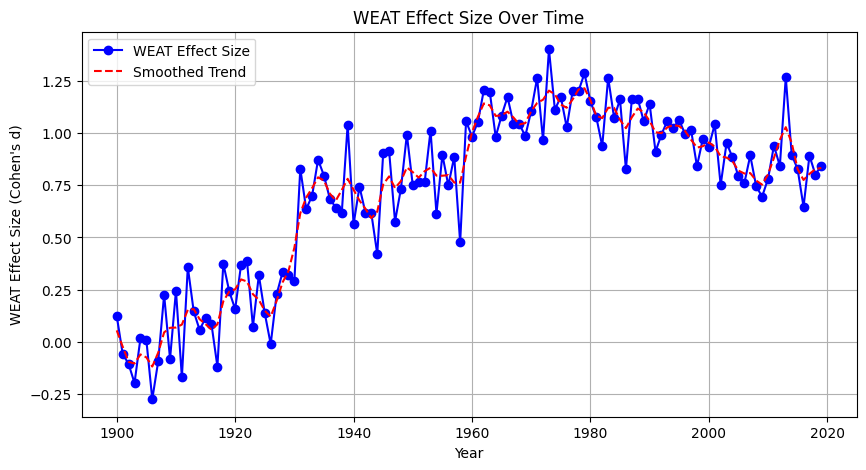

{1900: (0.123597085, None, None),
 1901: (-0.056378685, None, None),
 1902: (-0.105114006, None, None),
 1903: (-0.19635153, None, None),
 1904: (0.017524082, None, None),
 1905: (0.008915252, None, None),
 1906: (-0.27360022, None, None),
 1907: (-0.092086606, None, None),
 1908: (0.22590561, None, None),
 1909: (-0.08115697, None, None),
 1910: (0.24549486, None, None),
 1911: (-0.16913334, None, None),
 1912: (0.35810342, None, None),
 1913: (0.14597617, None, None),
 1914: (0.05734609, None, None),
 1915: (0.116016515, None, None),
 1916: (0.08473425, None, None),
 1917: (-0.11727335, None, None),
 1918: (0.37499073, None, None),
 1919: (0.2423039, None, None),
 1920: (0.1569982, None, None),
 1921: (0.37021136, None, None),
 1922: (0.38682416, None, None),
 1923: (0.073529564, None, None),
 1924: (0.31973833, None, None),
 1925: (0.13767554, None, None),
 1926: (-0.010241651, None, None),
 1927: (0.22714104, None, None),
 1928: (0.33360678, None, None),
 1929: (0.3189211, None, No

In [12]:
target1 = ["socialist", "socialism"]
target2 = ["capitalist", "capitalism"]
attribute1 = ["good", "ideal", "wonderful", "excellent", "great", "fantastic", "amazing", "superb", "outstanding", "marvelous", "splendid", "brilliant", "fabulous", "terrific", "admirable", "commendable", "exemplary", "praiseworthy", "superior", "stellar", "notable", "positive", "advantageous", "desirable"]
attribute2 = ["bad", "evil", "destructive", "terrible", "horrible", "awful", "dreadful", "abysmal", "atrocious", "appalling", "ghastly", "wicked", "villainous", "corrupt", "harmful", "damaging", "deplorable", "noxious", "pernicious", "heinous", "malevolent", "diabolical", "negative", "undesirable"]

compute_weat_over_years(
    target1,
    target2,
    attribute1,
    attribute2,
    start_year=1900,
    end_year=2019,
    model_dir="/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models_final/norm_and_align/",
    num_permutations=0,
    plot=1,
    smooth=True,
    sigma=1,
    return_std=False
)